# GAN Inversion

In this project, we will invert an image using <https://github.com/rosinality/stylegan2-pytorch> pretrained model.
A gan works by passin a `z` vector as input, and the output of the GAN is an image.

![](GAN_Arch.png)

In this task, we want to do the opposite, given an image, we want to find the corresponding latent vector `z`.
This is not as simple as a forward pass, you will need to optimize a `z` vector that happens to output a close match to our target image.

optimization process|target image `INVERTME.png`
-|-
![](conv.gif)|![](INVERTME.png)


## Introduction

### Guidelines

Outline:

1. download and import styleGAN 256x256 <https://github.com/rosinality/stylegan2-pytorch>
2. generate one or more images using styleGAN (just to get to know how it works)
3. invert the image: `INVERTME.png` (find the latent vector `z` that outputs an image similar to `INVERTME.png`
4. save/print this `z` vector
5. write a detailed report explaining the process


You are allowed to and encouraged to browse the web for help.

[PyTorch](https://pytorch.org/) is the preferred framework.

### Evaluation

You can solve this in any way, however you will be evaluated on the method you used.

Evaluation will be based on:

- code is functional (it works)
- explaination and report

**Note:** The evaluation will be based on the submitted report. Please provide detailed explaination of every step and method you use. 

### Tips

- Use the internet!
- Take your time reading, in fact go over the entire notebook first before writing anything
- Ask for help if you get stuck
- If one thing doesn't work, try something else (even if it's sub-optimal)
- Check your output often, check the data shape makes sense and plot images to prevent confusion or errors
- Keep track of time
- Don't forget to enjoy and benefit from the excercise :)

### Setup

This is a [jupyter notebook](https://jupyter.org/),
here are some [keyboard shortcuts](http://maxmelnick.com/2016/04/19/python-beginner-tips-and-tricks.html) to get you started.

You can run terminal commands using `!` such as:

```shell script
!echo "this is a command"
```


---

In [1]:
!nvidia-smi #Give me V100 for the love of god!

Tue Nov  7 21:42:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:1A:00.0 Off |                  N/A |
| 36%   31C    P8              29W / 370W |     14MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Copy files of the task to my colab content directory
!cp /content/drive/MyDrive/Task2_GANInversion/* . 

In [ ]:
# clone StyleGAN2 pytorch repo
!git clone https://github.com/rosinality/stylegan2-pytorch.git

In [2]:
# Python packages
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

Defaulting to user installation because normal site-packages is not writeable


### Generate samples 

Download [256x256 pretrained model](https://drive.google.com/open?id=1PQutd-JboOCOZqmd95XWxWrO8gGEvRcO) FFHQ. Since we are loading a checkpoint, we need to add ```strict=False``` parameter to ```load_state_dict``` in ```generate.py``` (line 76)

In [6]:
# directory for stylegan2-pytorch
!mkdir sample 

In [2]:
# using custom checkpoint, adding strict=False to generate.py file (Line 76) since we are loading a model
!python stylegan2-pytorch/generate.py --size 256 --sample 1 --pics 3 --ckpt 550000.pt

/bin/bash: line 1: python: command not found


000000.png  000001.png	000002.png  000003.jpeg



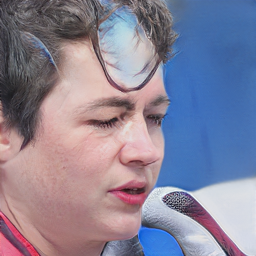

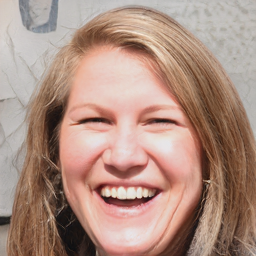

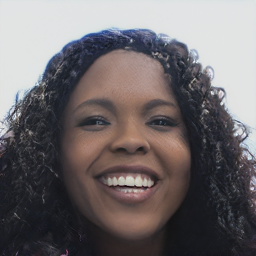

In [3]:
# display 3 pictures
!ls sample
from IPython.display import Image
from IPython.display import display

for i in range(3):
  print("")
  display(Image(f"sample/00000{i}.png"))

# Invert image back to latent space

## Introduction
In this section, we would try to invert an image "INVERTME.png" back into the latent space to obtain its latent code. This process involves manipulating Rosinality's [StyleGAN2-PyTorch code](https://github.com/rosinality/stylegan2-pytorch/blob/master/projector.py) provided in earlier section. Before jumping to the task, we want to understand what is GAN inversion. The primary concept is to provide an understanding of the latent space by inverting an image back to the latent space to gain its latent code.<br>

## GAN Inversion
The cool idea of GAN inversion is to navigate latent space. To elaborate, knowing the latent code would allow us to manipulate images for a specific task. In order to do that, we encourage our model (in this case StyleGAN2 has done it) to achieve disentaglement. Having the ability to encode disentangled semantic information (for example, babies tend to have primary teeth while adults have permanent teeth) allow us to find the dicrection in the latent space referring to "teeth" and then we can edit that direction if we want to possibly add primary teeth to babies.

Disentangled z space meaning that each index position correspond to a single feature in the output; for example, first index refers to teeth, second index refers to hair, etc.. Changing the numbers in specific index would change its direction in the latent space allowing manipulation (i.e glasses, no glasses, small lips, bigger lips etc..). Disentaglement is important to obtain better interpretable directions in the latent space for attributes such as teeth, hair. 

From the [paper](https://arxiv.org/pdf/1812.04948.pdf), latent directions have been explored using unsupervised approach (for example, PCA) which permit us to identify directions without labelling them in advance. There is no fixed way to know that the 5th component for example is always going to be hair. Exploring each component is necessary to know which one refers to specific feature. 

## StyleGAN Architecture
What differs StyleGAN from traditional GAN is that the architecture starts from a constant input (z noise), normalized using pixel norm, and then mapping it to 8-layer multilayer perceptron (fully connected). This would output intermediate latent space W that has 512 dimensions (z space is also 512 dimension). That space controls the generator through adaptive instance normalization [(AdaIN)](https://youtu.be/idIHmtjz1EQ?t=77) at each convolution layer. Noise is added after each convolution before evaluating nonlinearity.

![0_nzmrf7VMLsTWt8SX](https://user-images.githubusercontent.com/49822946/156415769-4af5879a-779e-4dac-9bff-e581ebc1997c.png)

According to the paper, "A" here repersent a combination of linear transformation and translation, while "B" is simply Gaussian noise. 

Below is a StyleGAN in a simple form <br>
![0_N3-UCbXgKnIEavOj](https://user-images.githubusercontent.com/49822946/156415913-2428324e-7170-4025-8006-f8bd085342a1.png)


## Further explaination of the network and disentaglement in StyleGAN
Generally in GAN, the distribution of z should be similar to the latent distribution of real images. According to the authors in the paper, "The
input latent space must follow the probability density of the
training data, and we argue that this leads to some degree of
unavoidable entanglement." The figure below illustrates an example of two latent factors (masculinity and hair length). <br>
![image](https://user-images.githubusercontent.com/49822946/156419606-c85d5463-b680-4394-b753-c27937b8dd3c.png)

The missing upper left corner indicates that males are not allowed to have long hair. <br> If we sample the space uniformaly or normally, the generator will be able to pick up pieces to produce males with long hair. That is the goal of the mapping network in earlier [figure](https://user-images.githubusercontent.com/49822946/156415769-4af5879a-779e-4dac-9bff-e581ebc1997c.png), is to create untangled features to avoid feature combinations that didnt happen in the training dataset 
![image](https://user-images.githubusercontent.com/49822946/156421240-c1b6454d-e4f7-4012-92d6-0953c2af3a14.png)
<br>
That is the intermidiate latent space W the authors mention which is allowed to be disentangled; therefore, the generator appears to be more linear, less entangled repersentation of different factors of variation.

## Bonus: Z space, W space

First, we have to lay foundation that the latent space itself has no meaning. In general, GANs have the latent space that we draw stochastic noise vectors and typically the noise is isotropic gaussian distribution so the shape really doesnt give us any useful information about the model but is equally stretched in all directions. So we can say that the input space is not informative and the output space is very complex. Yet, it is possible to identify directions in this latent space where we can generate same image but with different context; for instance, an image of a person with beard from no beard, cars with different shapes, colors etc.. <br> 

This is done through the mapping network that maps input latent Z with intermediate latent space W. The thing that we most interested about is the intermediate latent space W that is fed into all subsequent layers in the generator. This allow us to move from an isotropic distribution to something very interesting to find these directions of change in the intermediate layer of the generator. 

Z space: istorpic gaussian distribution, not meaningful, feature entangled.<br>W space: to obtain more disentangled features.

To sum up, the input latent space is isotropic and not informative and the output space is highly complex and hard to reason about.

## Code:
[Code]( https://github.com/rosinality/stylegan2-pytorch/blob/master/projector.py) taken from with some modifications. I tried my best to comment each line of code to reflect in what is written in the paper.


In [4]:
import math
import os
import sys
sys.path.insert(0, 'stylegan2-pytorch/')
import numpy as np
import torch
from torch import optim
from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# change library import in lpips __init__.py  'from skimage.measure import compare_ssim' to 'from skimage.metrics import structural_similarity'
# Edit line 53 'compare_ssim' to 'structural_similarity', keep parameters as is.
import lpips

from model import Generator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [5]:
# Code taken from https://github.com/rosinality/stylegan2-pytorch/blob/master/projector.py with some modifications

# supporting functions
def noise_regularize(noises):
    loss = 0

    for noise in noises:
        size = noise.shape[2]

        while True:
            loss = (
                
                loss
                + (noise * torch.roll(noise, shifts=1, dims=3)).mean().pow(2)
                + (noise * torch.roll(noise, shifts=1, dims=2)).mean().pow(2)
            )

            if size <= 8:
                break

            noise = noise.reshape([-1, 1, size // 2, 2, size // 2, 2])
            noise = noise.mean([3, 5])
            size //= 2

    return loss


def noise_normalize_(noises):
    for noise in noises:
        mean = noise.mean()
        std = noise.std()

        noise.data.add_(-mean).div_(std)


def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp


def latent_noise(latent, strength):
    noise = torch.randn_like(latent) * strength

    return latent + noise


def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(0, 2, 3, 1)
        .to("cpu")
        .numpy()
    )


In [1]:
# Modified code to generate images close to our inverted latent
def calculate_psnr(target, output):
    mse_loss = F.mse_loss(output, target)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse_loss))
    return psnr.item()

def invert_to_latent(images, ckpt):
  TARGET = mpimg.imread(images[0])
  n_mean_latent = 10000
  device = "cuda"
  resize = 256
  STEP = 10000
  LR = 0.1
  NOISE = 0.05
  NOISE_RAMP = 0.75
  NOISE_REGULARIZE = 1e5
  MSE = 0
  z_history = []
  

  transform = transforms.Compose(
      [
          transforms.Resize(resize),
          transforms.CenterCrop(resize),
          transforms.ToTensor(),
          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
      ]
  )

  imgs = []
  for imgfile in images:
      img = transform(Image.open(imgfile).convert("RGB"))
      imgs.append(img)
      
  imgs = torch.stack(imgs, 0).to(device)

  # load generator model
  g_ema = Generator(resize, 512, 8) # using 8-layer MLP to generate w
  g_ema.load_state_dict(torch.load(ckpt)["g_ema"], strict=False) # pretrained weights
  g_ema.eval()
  g_ema = g_ema.to(device)
  

  with torch.no_grad():
      noise_sample = torch.randn(n_mean_latent, 512, device=device) # Z noise
      
      latent_out = g_ema.style(noise_sample)  # returns W which goes through first pixelnorms and then through the 8 layers MLP

      latent_mean = latent_out.mean(0) # A from paper which is used in AdaIN???
      latent_std = ((latent_out - latent_mean).pow(2).sum() / n_mean_latent) ** 0.5
      # print("#### LATENT_MEAN ####")
      # print(latent_mean) #test

  percept = lpips.PerceptualLoss(
      model="net-lin", net="vgg", use_gpu=device.startswith("cuda")
  )

  noises_single = g_ema.make_noise() # B from paper
  noises = []
  for noise in noises_single:
      noises.append(noise.repeat(imgs.shape[0], 1, 1, 1).normal_())
  
  # print("#### NOISES ####")
  # print(noises) #test

  latent_in = latent_mean.detach().clone().unsqueeze(0).repeat(imgs.shape[0], 1) # A from the paper

  # Check where is AdaIN


  # if True: # CHECK LATER
  #   latent_in = latent_in.unsqueeze(1).repeat(1, g_ema.n_latent, 1)

  latent_in.requires_grad = True

  for noise in noises:
      noise.requires_grad = True

  optimizer = optim.Adam([latent_in] + noises, lr=LR)

  pbar = tqdm(range(STEP))
  latent_path = []

  for i in pbar:
      t = i / STEP
      lr = get_lr(t, LR)
      optimizer.param_groups[0]["lr"] = lr
      noise_strength = latent_std * NOISE * max(0, 1 - t / NOISE_RAMP) ** 2
      #print(noise_strength)
      #print(latent_in.shape, noise_strength.shape)

      latent_n = latent_noise(latent_in, noise_strength.item()) # W, check model.py generator code
      img_gen, z_latent = g_ema([latent_n], input_is_latent=True, noise=noises, return_latents=True) #returns z latent

      batch, channel, height, width = img_gen.shape

      if height > 256:
          factor = height // 256

          img_gen = img_gen.reshape(
              batch, channel, height // factor, factor, width // factor, factor
          )
          img_gen = img_gen.mean([3, 5])

      p_loss = percept(img_gen, imgs).sum()
      n_loss = noise_regularize(noises)
      mse_loss = F.mse_loss(img_gen, imgs)
      psnr = calculate_psnr(img_gen, imgs)

      loss = p_loss + NOISE_REGULARIZE * n_loss + MSE * mse_loss

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      noise_normalize_(noises)
      # tab = '\t'
      # newline = '\n'
      if (i + 1) % 100 == 0:
          latent_path.append(latent_in.detach().clone())
          z_history.append(z_latent)
          # print(newline, "GENERATED: ", tab, "TARGET: ")
          
          # Display generated, target images
          fig, ax = plt.subplots(1,2, figsize=(10,5))
          ax[0].set_title("GENERATED")
          ax[1].set_title("TARGET")
          ax[0].set_xticklabels("")
          ax[1].set_xticklabels("")
          ax[0].set_yticklabels("")
          ax[1].set_yticklabels("")
          ax[0].imshow(make_image(img_gen)[0])
          ax[1].imshow(TARGET)
          plt.show()
          print("")
          print(z_latent.shape)
          # plt.imshow(make_image(img_gen)[0])
          # display(Image.fromarray(make_image(img_gen)[0]), TARGET) # FIX AXES!!!!!!

      pbar.set_description(
          (
              f"perceptual: {p_loss.item():.4f}; noise regularize: {n_loss.item():.4f};"
              f"psnr:{psnr} mse: {mse_loss.item():.4f}; lr: {lr:.4f}"
          )
      )

  img_gen, _ = g_ema([latent_path[-1]], input_is_latent=True, noise=noises)

  # filename = os.path.splitext(os.path.basename(image[0]))[0] + ".pt"
   

  img_ar = make_image(img_gen)
  #save_image(img_ar, f"inverted_.png")
  

  result_file = {}
  for i, input_name in enumerate(images):
    noise_single = []
    for noise in noises:
      noise_single.append(noise[i : i + 1])

    result_file[input_name] = {
        "img": img_gen[i],
        "latent": latent_in[i],
        "noise": noise_single,
    }

    return result_file, img_ar, latent_path, z_history
  
def calculate_psnr(target, output):
    mse_loss = F.mse_loss(output, target)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse_loss))
    return psnr.item()

def get_latent_codes_for_folder(folder, ckpt, invert_func):
    latent_codes = []
    for img_file in os.listdir(folder):
        img_path = os.path.join(folder, img_file)
        result, _, _, _ = invert_func([img_path], ckpt)
        latent_codes.append(result[img_path]['latent'])
    return torch.stack(latent_codes)

# Function to generate an image from a given latent code using your generator
def generate_image_from_latent(latent_code, g_ema, device='cuda'):
    g_ema.eval()
    g_ema.to(device)
    latent_code = latent_code.to(device).unsqueeze(0)  # Add the batch dimension

    with torch.no_grad():
        img_gen, _ = g_ema([latent_code], input_is_latent=True)
        img_gen = img_gen.to('cpu').detach()

    return img_gen

# Function to save an image given a tensor
def save_image(tensor, filename):
    image = tensor.clamp(0, 1).permute(1, 2, 0).numpy()*255
    image = image.astype(np.uint8)
    img = Image.fromarray(image)
    img.save(filename)

# Function to load the StyleGAN2 model with the pre-trained weights
def load_stylegan2_model(ckpt_path, device):
    # Adjust the layer count and resolution to match the model you are using
    g_ema = Generator(size=256, style_dim=512, n_mlp=8).to(device)
    checkpoint = torch.load(ckpt_path)
    
    # If your checkpoint keys are different, adjust the key accordingly
    g_ema.load_state_dict(checkpoint["g_ema"], strict=False)
    g_ema.eval()
    return g_ema


Setting up Perceptual loss...
Loading model from: /home/myid/md40040/StyleGAN2/stylegan2-pytorch/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


perceptual: 0.3093; noise regularize: 0.0000;psnr:3.2720911502838135 mse: 0.4708; lr: 0.0016:  98%|█████████▊| 98/100 [00:09<00:00, 11.15it/s]

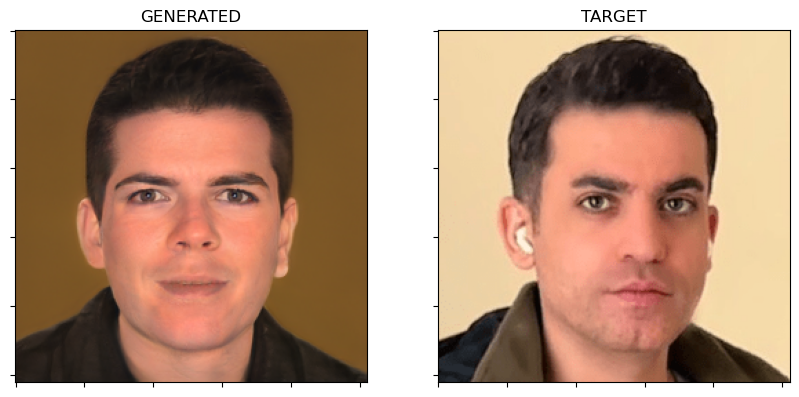

perceptual: 0.3093; noise regularize: 0.0000;psnr:3.2720212936401367 mse: 0.4708; lr: 0.0004: 100%|██████████| 100/100 [00:09<00:00, 10.59it/s]


torch.Size([1, 14, 512])


In [15]:
# Assuming 'ckpt_path' is the path to your model's checkpoint file
your_image_path = '000006.png'
ckpt_path = '550000.pt'  # Make sure this points to your actual checkpoint file.

# Load the StyleGAN2 model
device = 'cuda'  # or 'cpu' if you are not using a GPU
g_ema = load_stylegan2_model(ckpt_path, device)

# Invert your own image to get the latent representation
# Make sure to pass the correct arguments to the 'invert_to_latent' function
result, _, _, _ = invert_to_latent([your_image_path], ckpt_path)
z_original = result[your_image_path]['latent']


# Load the smile direction vector
smile_direction_path = 'smile_direction.pt'
smile_direction = torch.load(smile_direction_path)

# Apply the smile direction to your latent code
alpha = 0.75  # Adjust alpha to control the intensity of the smile
z_with_smile = z_original + alpha * smile_direction

# Generate the image with the added smile from the modified latent code
generated_image_tensor = generate_image_from_latent(z_with_smile, g_ema, device)

# Save the generated image
save_image(generated_image_tensor.squeeze(0), 'image_with_smile.png')

In [10]:
# w space shape for the last generated image
w_history[-1].shape

torch.Size([1, 512])

In [11]:
# W space for the last generated image
w_history[-1]

tensor([[-3.2227e+00, -1.9038e+00, -1.1985e+00, -7.9441e-01,  2.7210e+00,
         -2.1096e+00,  9.4260e-02, -5.0608e-01,  5.9669e-01,  1.7590e-01,
          1.3107e+00, -2.1391e-01,  1.1689e+00, -5.2804e-01,  5.9620e-02,
         -2.2273e+00,  3.0633e+00, -2.6842e+00,  1.3127e+00, -4.3504e-01,
          5.6622e-01,  9.5831e-01, -4.7916e-01,  1.4734e+00,  7.4253e-01,
          1.4807e-01, -3.9960e-01,  7.3556e-01, -5.6950e-01, -7.8668e-01,
          9.8712e-01, -1.7540e+00,  1.6612e+00,  1.0601e+00,  8.8063e-02,
         -7.3975e-01,  8.1027e-02,  6.4114e-01, -8.6520e-01,  1.9296e-01,
          3.4581e-01, -2.6918e-01,  6.6182e-01,  1.5343e+00,  1.7647e+00,
          8.4674e-01,  4.4152e-01, -1.5303e+00,  8.8243e-01,  1.8623e+00,
         -2.2809e-01,  2.4680e-01, -1.6732e+00,  3.0837e+00, -2.3902e+00,
         -3.6743e-01,  2.5461e-01,  1.6569e+00,  7.1770e-01, -1.1808e-01,
         -1.0599e+00,  8.6901e-01, -5.2692e-01,  1.4066e+00,  1.1459e+00,
          4.6750e-01, -5.2508e-02,  1.

In [40]:
# z space for the last generated image
z_history[-1].shape

torch.Size([1, 14, 512])

In [45]:
# latent z vector for the last generated image
z_history[-1]

tensor([[[-2.3153, -1.0816, -0.7689,  ..., -0.5701,  0.5576,  0.5915],
         [-2.3153, -1.0816, -0.7689,  ..., -0.5701,  0.5576,  0.5915],
         [-2.3153, -1.0816, -0.7689,  ..., -0.5701,  0.5576,  0.5915],
         ...,
         [-2.3153, -1.0816, -0.7689,  ..., -0.5701,  0.5576,  0.5915],
         [-2.3153, -1.0816, -0.7689,  ..., -0.5701,  0.5576,  0.5915],
         [-2.3153, -1.0816, -0.7689,  ..., -0.5701,  0.5576,  0.5915]]],
       device='cuda:0', grad_fn=<RepeatBackward0>)

## Reference

1. https://arxiv.org/pdf/1812.04948.pdf
2. https://www.youtube.com/watch?v=8L11aMN5KY8
3. https://github.com/rosinality/stylegan2-pytorch
4. https://arxiv.org/abs/1912.04958
5. https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d
6. https://github.com/jacobhallberg/pytorch_stylegan_encoder
7. https://towardsdatascience.com/stylegan2-ace6d3da405d
8. https://www.youtube.com/watch?v=u8qPvzk0AfY
9. https://medium.com/analytics-vidhya/from-gan-basic-to-stylegan2-680add7abe82
10. https://youtu.be/idIHmtjz1EQ?t=78
11. https://medium.com/analytics-vidhya/understanding-the-stylegan-and-stylegan2-architecture-add9e992747d
12. https://jonathan-hui.medium.com/gan-stylegan-stylegan2-479bdf256299
13. https://arxiv.org/pdf/2102.12139.pdf
